# Regression Analysis

By Evgenia "Jenny" Nitishinskaya and Delaney Granizo-Mackenzie. Algorithms by David Edwards.


Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)

Notebook released under the Creative Commons Attribution 4.0 License.

---

Regression analysis allows us to estimate coefficients in a function which approximately relates multiple data sets. We hypothesize a specific form for this function and then find coefficients which fit the data well, working under the assumption that deviations from the model can be considered noise.

When building such a model, we accept that it cannot perfectly predict the dependent variable. Here we would like to evaluate the accuracy of the model not by how well it explains the dependent variable, but by how <i>stable</i> it is (that is, how stable the regression coefficients are) with respect to our sample data. After all, if a model is truly a good fit, it should be similar, say, for two random halves of our data set that we model individually. Otherwise, we cannot assume that the model isn't simply an artifact of the particular sample of data we happened to choose, or that it will be predictive of new data points.

We'll be using linear regressions here for illustration purposes, but the same considerations apply for all regression models. Below we define a wrapper function for the linear regression from `statsmodels` so we can use it later.

In [1]:
import numpy as np
from statsmodels import regression, stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy as sp

def linreg(X,Y):
    # Running the linear regression
    x = sm.add_constant(X) # Add a row of 1's so that our model has a constant term
    model = regression.linear_model.OLS(Y, x).fit()
    return model.params[0], model.params[1] # Return the coefficients of the linear model

# Biased noise

The particular sample we choose for the data affects the model generated, and unevenly distributed noise can lead to an inaccurate model. Below we're drawing from a normal distribution, but because we do not have very many data points, we get a significant downward bias. If we took more measurements, both of the regression coefficients would move toward zero.

Slope: 0.00907250382269 Intercept: -0.402077440853


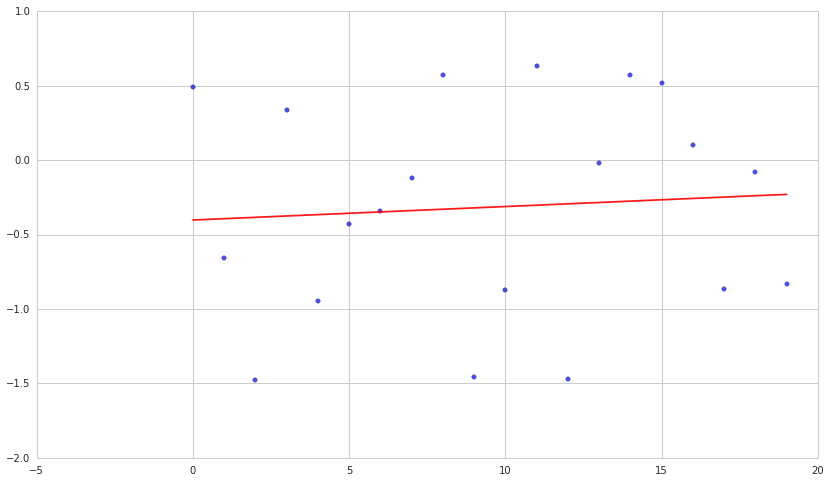

In [2]:
# Draw observations from normal distribution
np.random.seed(107) # Fix seed for random number generation
rand = np.random.randn(20)

# Conduct linear regression on the ordered list of observations
xs = np.arange(20)
a, b = linreg(xs, rand)
print 'Slope:', b, 'Intercept:', a

# Plot the raw data and the regression line
plt.scatter(xs, rand, alpha=0.7)
Y_hat = xs * b + a
plt.plot(xs, Y_hat, 'r', alpha=0.9);

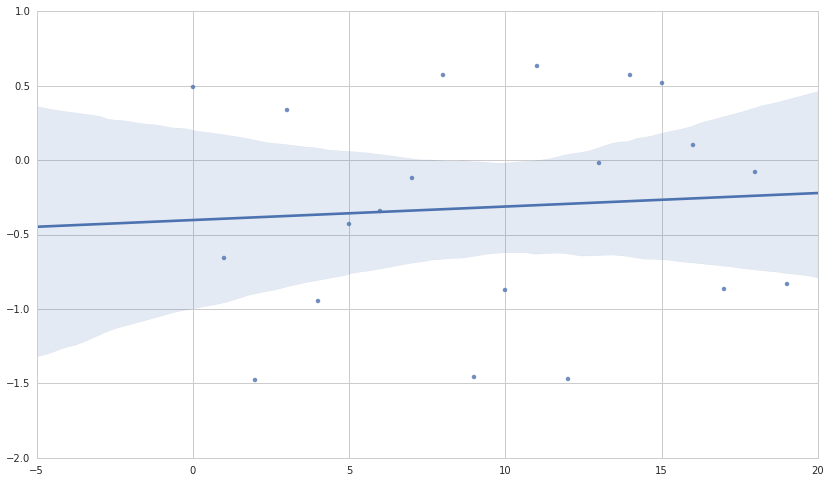

In [3]:
import seaborn

seaborn.regplot(xs, rand)

Slope: -0.000569342363105 Intercept: 0.00901176731902


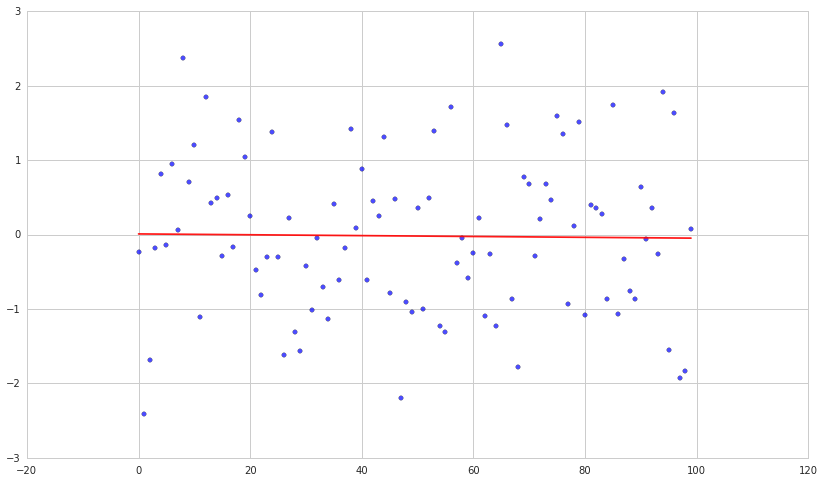

In [4]:
# Draw more observations
rand2 = np.random.randn(100)

# Conduct linear regression on the ordered list of observations
xs2 = np.arange(100)
a2, b2 = linreg(xs2, rand2)
print 'Slope:', b2, 'Intercept:', a2

# Plot the raw data and the regression line
plt.scatter(xs2, rand2, alpha=0.7)
Y_hat2 = xs2 * b2 + a2
plt.plot(xs2, Y_hat2, 'r', alpha=0.9);

Regression analysis is very sensitive to outliers. Sometimes these outliers contain information, in which case we want to take them into account; however, in cases like the above, they can simply be random noise. Although we often have many more data points than in the example above, we could have (for example) fluctuations on the order of weeks or months, which then significantly change the regression coefficients.

# Regime changes

A regime change (or structural break) is when something changes in the process generating the data, causing future samples to follow a different distribution. Below, we can see that there is a regime change at the end of 2007, and splitting the data there results in a much better fit (in red) than a regression on the whole data set (yellow). In this case our regression model will not be predictive of future data points since the underlying system is no longer the same as in the sample. In fact, the regression analysis assumes that the errors are uncorrelated and have constant variance, which is often not be the case if there is a regime change.

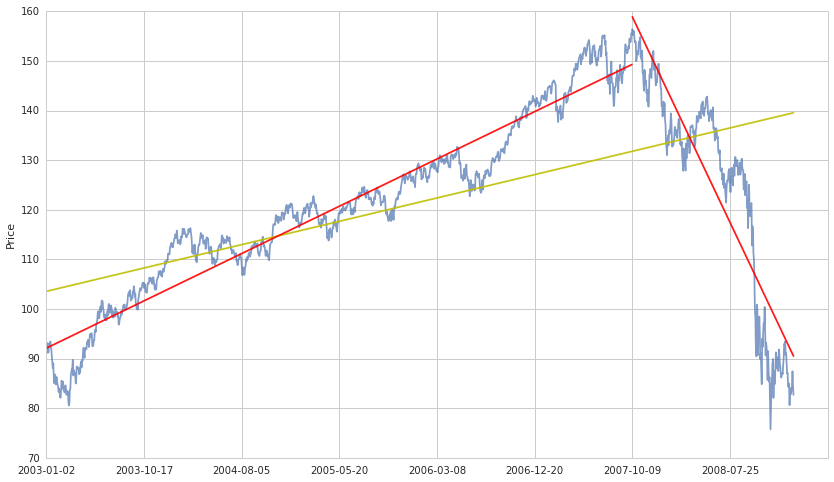

In [5]:
start = '2003-01-01'
end = '2009-02-01'
pricing = get_pricing('SPY', fields='price', start_date=start, end_date=end)

# Manually set the point where we think a structural break occurs
breakpoint = 1200
xs = np.arange(len(pricing))
xs2 = np.arange(breakpoint)
xs3 = np.arange(len(pricing) - breakpoint)

# Perform linear regressions on the full data set, the data up to the breakpoint, and the data after
a, b = linreg(xs, pricing)
a2, b2 = linreg(xs2, pricing[:breakpoint])
a3, b3 = linreg(xs3, pricing[breakpoint:])

Y_hat = xs * b + a
Y_hat2 = xs2 * b2 + a2
Y_hat3 = xs3 * b3 + a3

# Plot the raw data
_, ax = plt.subplots()
ax.plot(pricing, alpha=0.7)
ticks = ax.get_xticks()
ax.set_xticklabels([pricing.index[i].date() for i in ticks[:-1]]) # Label x-axis with dates

# Plot the regression lines
ax.plot(xs, Y_hat, 'y', alpha=0.9)
ax.plot(xs2, Y_hat2, 'r', alpha=0.9)
plt.plot(xs3 + breakpoint, Y_hat3, 'r', alpha=0.9);
plt.ylabel('Price')

Of course, the more pieces we break our data set into, the more precisely we can fit to it. It's important to avoid fitting to noise, which will always fluctuate and is not predictive. We can test for the existence of a structural break, either at a particular point we have identified or in general. Below we use a test from `statsmodels` which computes the probability of observing the data if there were no breakpoint.

In [6]:
stats.diagnostic.breaks_cusumolsresid(
    regression.linear_model.OLS(pricing, sm.add_constant(xs)).fit().resid)[1]

7.4485869571215107e-59

# Multicollinearity

Above we were only considering regressions of one dependent variable against one independent one. However, we can also have multiple independent variables. This leads to instability if the independent variables are highly correlated.

Imagine we are using two independent variables, $X_1$ and $X_2$, which are very highly correlated. Then the coefficients may shift drastically if we add a new observation that is slightly better explained by one of the two than by the other. In the extreme case, if $X_1 = X_2$, then the choice of coefficients will depend on the particular linear regression algorithm.

Below, we run a multiple linear regression in which the independent variables are highly correlated. If we take our sample period to be 2013-01-01 to 2015-01-01, then the coefficients are approximately .25 and .1. But if we extend the period to 2015-06-01, the coefficients become approximately .18 and .20, respectively.

Constant: -16.3503624604 MLR beta to S&P 500: 0.246866260161  MLR beta to MDY 0.0957537082372


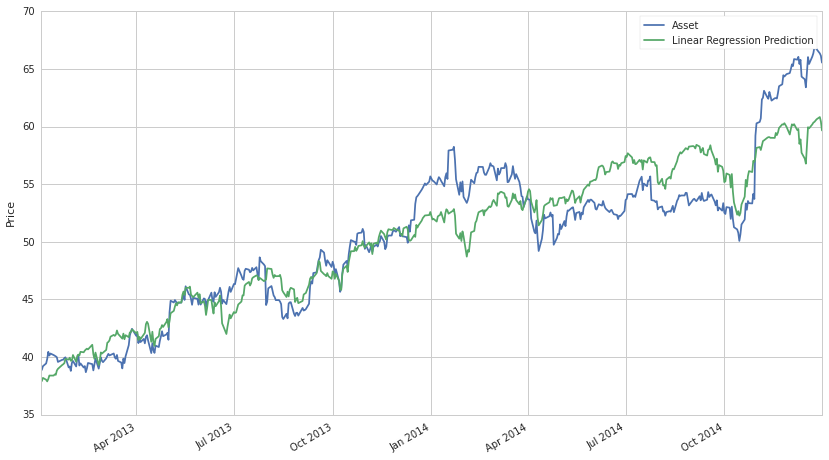

In [7]:
# Get pricing data for two benchmarks (stock indices) and a stock
start = '2013-01-01'
end = '2015-01-01'
b1 = get_pricing('SPY', fields='price', start_date=start, end_date=end)
b2 = get_pricing('MDY', fields='price', start_date=start, end_date=end)
asset = get_pricing('V', fields='price', start_date=start, end_date=end)

mlr = regression.linear_model.OLS(asset, sm.add_constant(np.column_stack((b1, b2)))).fit()
prediction = mlr.params[0] + mlr.params[1]*b1 + mlr.params[2]*b2
print 'Constant:', mlr.params[0], 'MLR beta to S&P 500:', mlr.params[1], ' MLR beta to MDY', mlr.params[2]

# Plot the asset pricing data and the regression model prediction, just for fun
asset.plot()
prediction.plot();
plt.ylabel('Price')
plt.legend(['Asset', 'Linear Regression Prediction'])

Constant: -28.5210310926 MLR beta to S&P 500: 0.176425363423  MLR beta to MDY 0.203681925802


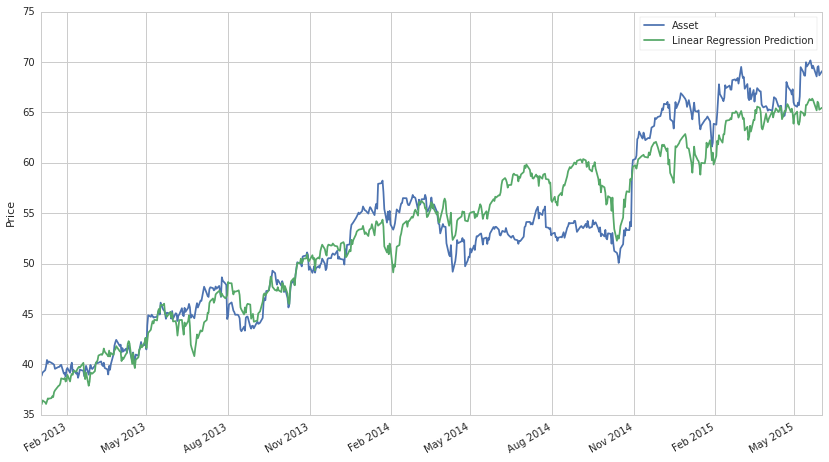

In [8]:
# Get pricing data for two benchmarks (stock indices) and a stock
start = '2013-01-01'
end = '2015-06-01'
b1 = get_pricing('SPY', fields='price', start_date=start, end_date=end)
b2 = get_pricing('MDY', fields='price', start_date=start, end_date=end)
asset = get_pricing('V', fields='price', start_date=start, end_date=end)

mlr = regression.linear_model.OLS(asset, sm.add_constant(np.column_stack((b1, b2)))).fit()
prediction = mlr.params[0] + mlr.params[1]*b1 + mlr.params[2]*b2
print 'Constant:', mlr.params[0], 'MLR beta to S&P 500:', mlr.params[1], ' MLR beta to MDY', mlr.params[2]

# Plot the asset pricing data and the regression model prediction, just for fun
asset.plot()
prediction.plot();
plt.ylabel('Price')
plt.legend(['Asset', 'Linear Regression Prediction'])

We can check that our independent variables are correlated by computing their correlation coefficient. This number always lies between -1 and 1, and a value of 1 means that the two variables are perfectly correlated.

In [9]:
# Compute Pearson correlation coefficient
sp.stats.pearsonr(b1,b2)[0] # Second return value is p-value

0.98870295660403051